## **Text Embeddings Extraction**

This notebook contains all the code to extract embeddings using the product descriptions

Adapt the libraries

In [ ]:
# Uninstalling libraries
!pip uninstall -y numpy transformers datasets peft jax jaxlib accelerate

# Installing libraries
!pip install numpy==1.24.4 jax jaxlib --quiet
!pip install transformers==4.38.2 datasets==2.18.0 peft==0.7.1 --quiet
!pip install accelerate==0.27.2 --quiet

# Restarting the colab session
import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Successfully uninstalled transformers-4.38.2
Found existing installation: datasets 2.18.0
Uninstalling datasets-2.18.0:
  Successfully uninstalled datasets-2.18.0
Found existing installation: peft 0.7.1
Uninstalling peft-0.7.1:
  Successfully uninstalled peft-0.7.1
Found existing installation: jax 0.4.38
Uninstalling jax-0.4.38:
  Successfully uninstalled jax-0.4.38
Found existing installation: jaxlib 0.4.38
Uninstalling jaxlib-0.4.38:
  Successfully uninstalled jaxlib-0.4.38
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires d

Import libraries

In [ ]:
# Importing
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from functools import partial
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from google.colab import drive, files
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Getting access to google drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the training dataset

In [ ]:
# Getting the available device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting the path of the drive
drive_path = "/content/drive/MyDrive/Data Science Challenge/deliverable/data/"

# Loading the training dataset
training_dataset = pd.read_excel(drive_path + "training_dataset.xlsx")

print(f"Print some rows:\n {training_dataset.head(5)}")

Print some rows:
    product_id                                        description  label
0           0  FSA Orbit 1.5ZS Zero Stack Internal Bicycle He...      5
1           1  Columbia Bugaboo II 12-Foot-by-9-Foot 4-Pole 5...     10
2           2     Men's New Gym Workout Short Gary Majdell Sport      0
3           3  Vktech Cute Creative Girls Tibet Silver Petal ...      7
4           4  Real Avid ZipWire Pistol Cleaning Kit Real Avi...      2


Split into training and validation datasets

In [ ]:
# Converting to lists
descriptions = training_dataset["description"].tolist()
labels = training_dataset["label"].tolist()

# Splitting the dataset into training and validation datasets
training_descriptions, validation_descriptions, training_labels, validation_labels = (
    train_test_split(
        descriptions,
        labels,
        test_size=0.2,
        random_state=42,
        stratify=labels,
    )
)

print(
    f"The number of samples in the training dataset is: {len(training_descriptions)}"
)
print(
    f"The number of samples in the validation dataset is: {len(validation_descriptions)}"
)

The number of samples in the training dataset is: 145604
The number of samples in the validation dataset is: 36402


Convert the datasets to Hugging Face dataset format

In [ ]:
# Converting

training_dataset = Dataset.from_dict(
    {"description": training_descriptions, "label": training_labels}
)
validation_dataset = Dataset.from_dict(
    {"description": validation_descriptions, "label": validation_labels}
)

Define a function to tokenize the product descriptions using a BERT tokenizer

In [ ]:
def tokenize_product_descriptions(dataset, bert_tokenizer):
    """
    This function is used to tokenize product descriptions using a BERT tokenizer.

    :param dataset: A Hugging Face dataset containing product descriptions
    :param bert_tokenizer: A BERT tokenizer
    :return: A dataset containing the tokenized descriptions
    """

    # Tokenizing
    tokenized_dataset = bert_tokenizer(
        dataset["description"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    return tokenized_dataset

Define a function for collecting the various losses across epochs after fine-tuning a BERT model

In [ ]:
def collect_losses(trainer):
    """
    This function is used to collect the training and validation losses
    from a Trainer object.

    :param trainer: A Trainer object
    :return: The training and validation losses
    """

    # Setting two lists keeping the training and validation losses
    training_losses, validation_losses = [], []

    # Iterating over the logs
    for log in trainer.state.log_history:

        # Checking for training loss
        if "loss" in log:

            # Updating
            training_losses.append(log["loss"])

        # Checking for validation loss
        if "eval_loss" in log:

            # Updating
            validation_losses.append(log["eval_loss"])

    return training_losses, validation_losses

Define a function to compute classification metrics during the training

In [ ]:
def compute_classification_metrics(validation_predictions):
    """
    This functions is used to compute some classification metrics during
    the training of a BERT model.

    :param validation_predictions: The predictions of the model on the validation set
    :return: A dictionary containing the computed metrics
    """

    # Unpacking (logits and true labels)
    logits, labels = validation_predictions

    # Getting the predicted labels
    predictions = np.argmax(logits, axis=1)

    # Computing metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1_score,
    }

Define a class that overrides the forward function of the BERT model to take into consideration the class weights

In [ ]:
class WeightedTrainer(nn.Module):

    def __init__(self, model, class_weights):
        """
        The constructor of the weighted trainer.

        :param model: The model to be trained
        :param class_weights: The class weights to be used
        """

        # Calling the constructor of the super class
        super().__init__()

        # Setting the object variables
        self.model = model
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask, labels, **kwargs):
        """
        The forward function of the weighted trainer.

        :param input_ids: The input tensor
        :param attention_mask: The attention mask tensor
        :param labels: The labels tensor
        :return: The output tensor
        """

        # Passing to the forward function of the model
        model_outputs = self.model(
            input_ids=input_ids, attention_mask=attention_mask, labels=None, **kwargs
        )

        # Getting the relevant logits
        logits = model_outputs.logits

        # Initializing the current loss
        current_loss = None

        # Checking for labels
        if labels is not None:

            # Setting the cross-entropy loss considering the class weights
            cr_en_loss = nn.CrossEntropyLoss(
                weight=self.class_weights.to(logits.device)
            )

            # Computing
            current_loss = cr_en_loss(logits, labels)

        # Checking and returning accordingly
        if current_loss is not None:

            return {"loss": current_loss, "logits": logits}

        else:

            return {"logits": logits}

Define a function for training a BERT model

In [ ]:
def train_bert_model(bert_model, bert_model_name, training_dataset, validation_dataset):
    """
    This function is used to train a BERT model for text classification.

    :param bert_model: A BERT model
    :param bert_model_name: The name of the BERT model
    :param training_dataset: A Hugging Face dataset for training
    :param validation_dataset: A Hugging Face dataset for validation
    :return: A Trainer object
    """

    # Defining the training arguments
    training_arguments = TrainingArguments(
        output_dir=f"./{bert_model_name}_results",
        learning_rate=2e-4,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        weight_decay=0.01,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        logging_strategy="epoch",
        num_train_epochs=10,
        load_best_model_at_end=True,
        metric_for_best_model="loss",
        greater_is_better=False,
        report_to="none",
    )

    # Defining the Trainer
    trainer = Trainer(
        bert_model,
        training_arguments,
        train_dataset=training_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_classification_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # Training the model
    trainer.train()

    return trainer

Tokenize the datasets

In [ ]:
# Setting the BERT model to use
bert_model_name = "distilbert-base-uncased"

# Loading the relevant BERT tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Creating a partial function to pass parameters to the 'tokenize' function
pass_parameters = partial(tokenize_product_descriptions, bert_tokenizer=bert_tokenizer)

# Tokenizing the descriptions
tokenized_training_dataset = training_dataset.map(pass_parameters, batched=True)
tokenized_validation_dataset = validation_dataset.map(pass_parameters, batched=True)

# Converting the datasets to PyTorch tensors for efficient processing
tokenized_training_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)
tokenized_validation_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/145604 [00:00<?, ? examples/s]

Map:   0%|          | 0/36402 [00:00<?, ? examples/s]

Apply LoRA

In [ ]:
# Loading the pre-trained BERT model for classification task
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name, num_labels=16
)

# Counting the model's total parameters
total_parameters = sum(parameter.numel() for parameter in bert_model.parameters())

# Counting the model's trainable parameters
total_trainable_parameters = sum(
    parameter.numel()
    for parameter in bert_model.parameters()
    if parameter.requires_grad
)

print(
    f"\nThe total parameters of the '{bert_model_name}' model is: {total_parameters}"
)
print(
    f"The trainable parameters of the '{bert_model_name}' model is: {total_trainable_parameters}\n"
)

# Setting a LoRA configuration
lora_configuration = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.05,
    task_type="SEQ_CLS",
)

# Appling LoRA to the BERT model
bert_model = get_peft_model(bert_model, lora_configuration)

# Printing the final trainable parameters after using LoRA
bert_model.print_trainable_parameters()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



The total parameters of the 'distilbert-base-uncased' model is: 66965776
The trainable parameters of the 'distilbert-base-uncased' model is: 66965776

trainable params: 750,352 || all params: 67,716,128 || trainable%: 1.1080846205500705


Train the BERT model

In [ ]:
# Computing the class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(training_labels), y=training_labels
)

# Converting to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Setting the weighted trainer
model = WeightedTrainer(bert_model, class_weights_tensor)

# Training
trainer = train_bert_model(
    model,
    bert_model_name,
    tokenized_training_dataset,
    tokenized_validation_dataset,
)

# Collecting the losses
training_losses, validation_losses = collect_losses(trainer)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.637600,0.427077,0.858799,0.867344,0.858799,0.860640
2,0.416700,0.360163,0.876820,0.885478,0.876820,0.878362
3,0.345900,0.347170,0.894731,0.896560,0.894731,0.894939
4,0.298000,0.325614,0.901434,0.904717,0.901434,0.902253
5,0.262400,0.313747,0.900692,0.904439,0.900692,0.901388
6,0.237900,0.322729,0.906461,0.909607,0.906461,0.907145
7,0.216000,0.314935,0.910747,0.913224,0.910747,0.911357
8,0.197100,0.316594,0.906379,0.910831,0.906379,0.907240


Show a classification report

In [ ]:
# Predicting on the validation dataset
predictions = trainer.predict(tokenized_validation_dataset)

# Extracting the logits
logits = predictions.predictions

# Getting the true labels
true_labels = predictions.label_ids

# Getting the predicted labels
predicted_labels = logits.argmax(axis=1)

print(classification_report(true_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.9636    0.9690    0.9663      3033
           1     0.8564    0.8925    0.8741      2372
           2     0.9414    0.8484    0.8925      8652
           3     0.9250    0.9655    0.9448      1073
           4     0.8868    0.9347    0.9101      3016
           5     0.9323    0.9313    0.9318      3565
           6     0.9007    0.9375    0.9187      1519
           7     0.9562    0.9198    0.9376      3752
           8     0.9263    0.9460    0.9361      1316
           9     0.9181    0.9181    0.9181       903
          10     0.8081    0.8426    0.8250      3589
          11     0.8929    0.9011    0.8970      1425
          12     0.6957    0.8794    0.7768      1318
          13     0.7955    0.8793    0.8353       323
          14     0.9008    0.9646    0.9316       226
          15     0.8739    0.9313    0.9017       320

    accuracy                         0.9007     36402
   macro avg     0.8859   

Show loss in training and validation data at all epochs

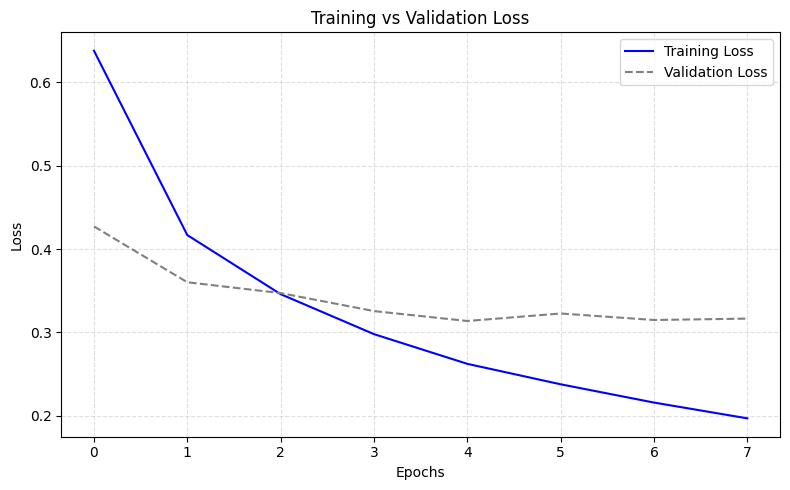

In [ ]:
# Creating a figure
plt.figure(figsize=(8, 5))

# Plotting the curves
plt.plot(training_losses, label="Training Loss", linestyle="-", color="blue")
plt.plot(validation_losses, label="Validation Loss", linestyle="--", color="grey")

# Setting some plot parameters
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.xticks(range(len(training_losses)))
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.8, alpha=0.4)

# Showing
plt.tight_layout()
plt.show()

Load and process all the product descriptions

In [ ]:
# Loading
product_descriptions = pd.read_excel(drive_path + "product_descriptions.xlsx")

# Tokenizing the product descriptions
tokenized_product_descriptions = bert_tokenizer(
    product_descriptions["description"].values.tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt",
)

# Moving to the available device
input_ids = tokenized_product_descriptions["input_ids"].to(device)
attention_mask = tokenized_product_descriptions["attention_mask"].to(device)

# Creating a tensor dataset
dataset = TensorDataset(input_ids, attention_mask)

# Creating a data loader
dataloader = DataLoader(dataset, batch_size=32)

Extract the text embeddings from the product descriptions

In [ ]:
# Setting a list for all the text embeddings
all_embeddings = []

# Removing the classification head
model = trainer.model.model.model.distilbert

# Putting the model in evaludation mode
model.eval()

# Moving to the available device
model.to(device)

# Using without backpropagation
with torch.no_grad():

    # Iterating over the batches
    for input_ids, attention_mask in dataloader:

        # Getting the outputs of the model
        model_outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Getting the CLS embeddings of the current batch
        batch_embeddings = model_outputs.last_hidden_state[:, 0, :]

        # Appending
        all_embeddings.append(batch_embeddings.cpu())

# Getting the final text embeddings
text_embeddings = torch.cat(all_embeddings, dim=0)

# Saving the text embeddings
torch.save(text_embeddings, drive_path + "text_embeddings.pt")

print(f"The shape of the tensor is:\n {text_embeddings.shape}")
print(f"Print some rows:\n {text_embeddings[:5]}")

The shape of the tensor is:
 torch.Size([276453, 768])
Print some rows:
 tensor([[ 0.6034,  0.0463,  0.4637,  ...,  0.3687, -0.0919, -1.3693],
        [ 0.8075,  0.7831, -0.7214,  ...,  0.5905,  0.9325,  0.3683],
        [ 1.2080, -0.8222, -1.2737,  ...,  0.5577,  0.2600, -0.4325],
        [ 1.0233,  0.7112,  0.5911,  ...,  0.5450, -0.0885, -0.1628],
        [-0.0537,  1.6462, -0.2172,  ..., -0.7644, -0.3311, -0.3493]])
